In [68]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras import layers
from keras import initializers
from keras.optimizers import Adam

## Generator

Generator as an input will take vector of length 100 with random numbers in range (0, 1)

In [70]:
generator = Sequential()
generator.add(layers.Dense(256, input_shape=(100,), kernel_initializer=initializers.RandomNormal(stddev = 0.02)))
generator.add(layers.LeakyReLU(alpha=0.2))
generator.add(layers.Dense(512))
generator.add(layers.LeakyReLU(alpha=0.2))
generator.add(layers.Dense(1024))
generator.add(layers.LeakyReLU(alpha=0.2))
generator.add(layers.Dense(28*28, activation='tanh'))

In [71]:
optimizer = Adam(lr=0.0002, beta_1=0.5)
generator.compile(optimizer= optimizer, loss='binary_crossentropy')
generator.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_23 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
dense_32 (Dense)             (None, 784)             

In [72]:
def generate_images(count=1):
    input = np.random.normal(0, 1, size=[count, 100])
    images = generator.predict(input)
    images *= 255 # pixels should be in range 0-255
    images = images.reshape((count, 28, 28))
    return images
    

Untrained generator generates something like that

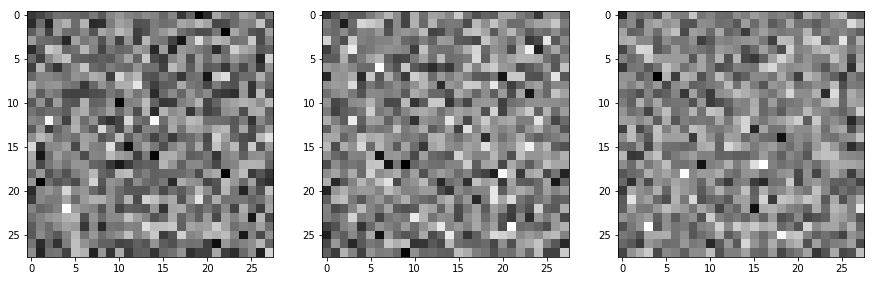

In [73]:
image = generate_images(3)
plt.figure(figsize=(15,5))
for i in range(3):
    plt.subplot('13{0}'.format(i+1))
    plt.imshow(image[i], cmap='gray')
plt.show()

## Discriminator

Discriminator will try to detect if the input image is made by generator or it is real.

In [74]:
discriminator = Sequential()
discriminator.add(layers.Dense(1024, input_dim=784))
discriminator.add(layers.LeakyReLU(0.2))
discriminator.add(layers.Dropout(0.3))
discriminator.add(layers.Dense(512))
discriminator.add(layers.LeakyReLU(0.2))
discriminator.add(layers.Dropout(0.3))
discriminator.add(layers.Dense(256))
discriminator.add(layers.LeakyReLU(0.2))
discriminator.add(layers.Dropout(0.3))
discriminator.add(layers.Dense(1, activation='sigmoid'))


In [75]:
discriminator.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
discriminator.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_34 (Dense)             (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 256)             

## GAN - Generative Adversarial Network

In [76]:
gan = Sequential()
gan.add(generator)
discriminator.trainable = False
gan.add(discriminator)
gan.compile(optimizer=optimizer, loss='binary_crossentropy')
gan.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_11 (Sequential)   (None, 784)               1486352   
_________________________________________________________________
sequential_12 (Sequential)   (None, 1)                 1460225   
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________


### training

In [77]:
train_data = pd.read_csv('../input/digit-recognizer/train.csv')
samples = train_data.drop(columns='label').values
samples = samples/255 - 1

In [87]:
history = pd.DataFrame(columns=['d_loss', 'd_acc', 'gan_loss'])

In [88]:

def train(batch_size=32, epochs=1):
    half_batch_size = np.floor(batch_size/2).astype(np.int32)
    steps = int(len(samples)/batch_size)
    for epoch in range(epochs):
        for step in range(steps):
            y = np.zeros(batch_size) #fake_images
            y[:half_batch_size] = 0.9  # real images
            generated_images = generator.predict(np.random.normal(0, 1, size=[half_batch_size, 100]))
            real_images = samples[np.random.randint(0, samples.shape[0], size=half_batch_size)]
            x = np.concatenate((generated_images,real_images))
            discriminator.trainable = True
            d_metrics = discriminator.train_on_batch(x, y)
            noise = np.random.normal(0, 1, size=[batch_size, 100])
            discriminator.trainable = False
            gan_loss = gan.train_on_batch(noise, np.zeros(batch_size))
            history.loc[epoch*steps+steps] = [d_metrics[0], d_metrics[1], gan_loss]
        # visualize training progress
        str = f'Epoch {epoch}: [D loss: {d_metrics[0]} acc: {d_metrics[1]}] | [G loss: {gan_loss}'
        print(str)
        images = generate_images(9)
        plt.figure(figsize=(15,5))
        for i in range(9):
            plt.subplot('19{0}'.format(i+1))
            plt.imshow(images[i], cmap='gray_r' ,interpolation='nearest')
        plt.show()


    return history

Epoch 0: [D loss: 0.6205787658691406 acc: 0.359375] | [G loss: 0.6915358304977417


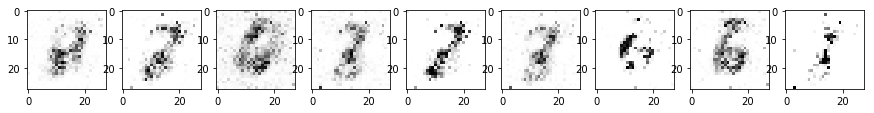

Epoch 1: [D loss: 0.6063278913497925 acc: 0.375] | [G loss: 0.701300859451294


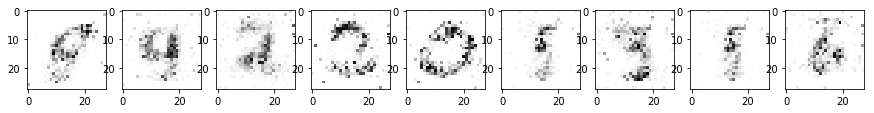

Epoch 2: [D loss: 0.657744288444519 acc: 0.296875] | [G loss: 0.6984967589378357


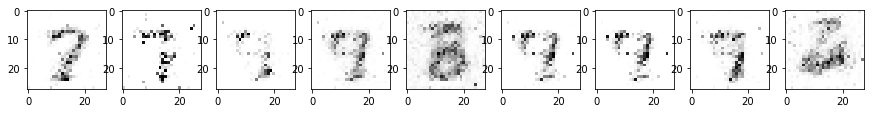

Epoch 3: [D loss: 0.6512191891670227 acc: 0.359375] | [G loss: 0.7275501489639282


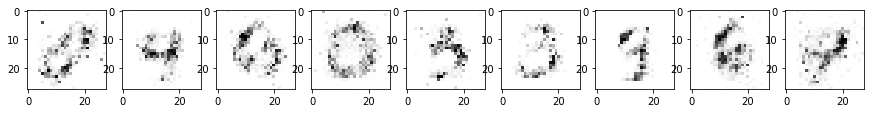

Epoch 4: [D loss: 0.6475832462310791 acc: 0.328125] | [G loss: 0.6095691323280334


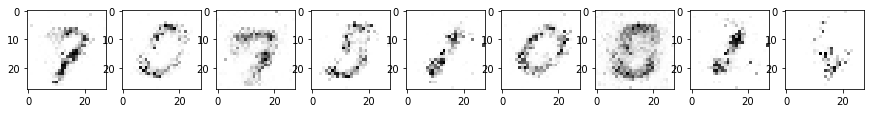

Epoch 5: [D loss: 0.6522457003593445 acc: 0.375] | [G loss: 0.6793503761291504


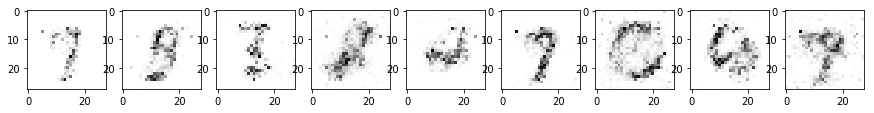

Epoch 6: [D loss: 0.7012313604354858 acc: 0.1796875] | [G loss: 0.6500622034072876


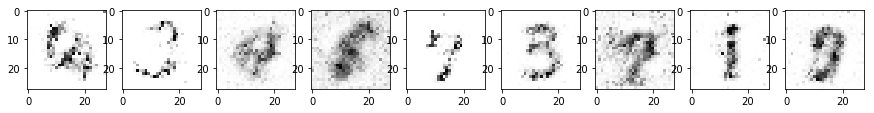

Epoch 7: [D loss: 0.6542600393295288 acc: 0.3671875] | [G loss: 0.7470335960388184


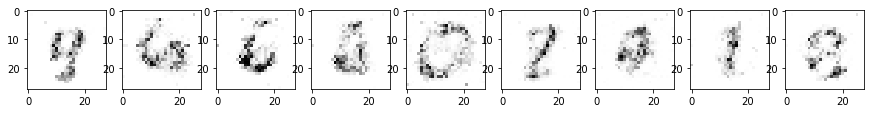

Epoch 8: [D loss: 0.6622377038002014 acc: 0.3984375] | [G loss: 0.6649246215820312


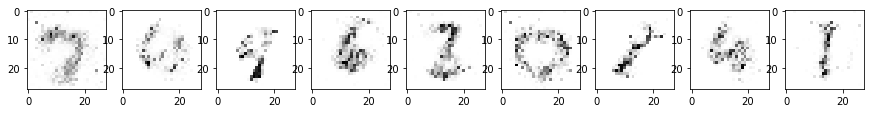

Epoch 9: [D loss: 0.6651020050048828 acc: 0.3828125] | [G loss: 0.7128369808197021


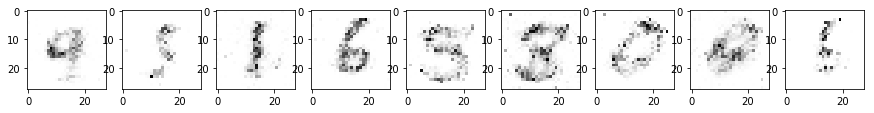

Epoch 10: [D loss: 0.6642467975616455 acc: 0.2890625] | [G loss: 0.6858021020889282


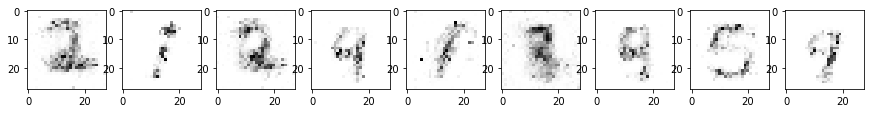

Epoch 11: [D loss: 0.6766729354858398 acc: 0.4609375] | [G loss: 0.6658427715301514


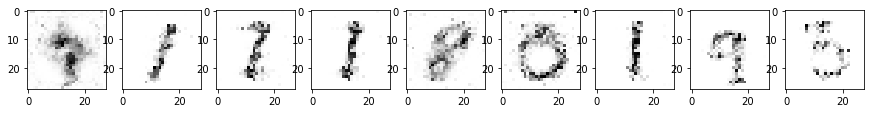

Epoch 12: [D loss: 0.6738017797470093 acc: 0.359375] | [G loss: 0.6789067983627319


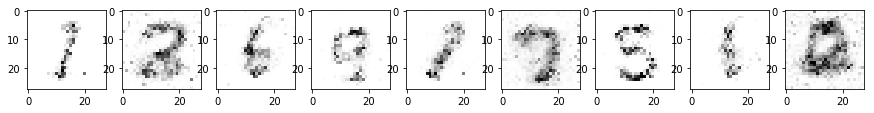

Epoch 13: [D loss: 0.6956415176391602 acc: 0.34375] | [G loss: 0.5870879888534546


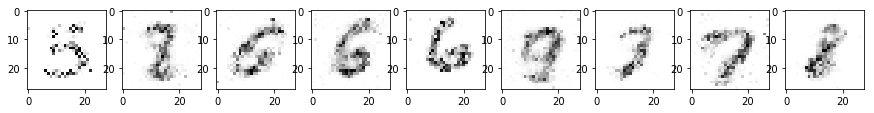

Epoch 14: [D loss: 0.6779035329818726 acc: 0.3984375] | [G loss: 0.5991992950439453


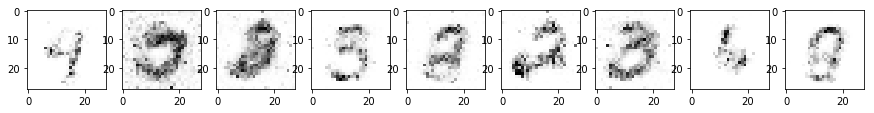

Epoch 15: [D loss: 0.6861154437065125 acc: 0.3828125] | [G loss: 0.5955885648727417


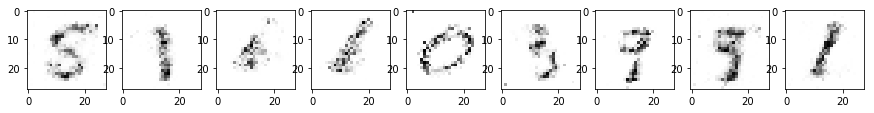

Epoch 16: [D loss: 0.675853967666626 acc: 0.3671875] | [G loss: 0.6217474937438965


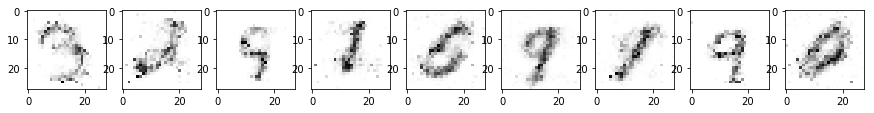

Epoch 17: [D loss: 0.6876646280288696 acc: 0.3359375] | [G loss: 0.6747362613677979


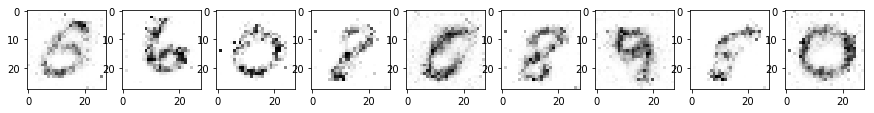

Epoch 18: [D loss: 0.6881590485572815 acc: 0.46875] | [G loss: 0.6298574209213257


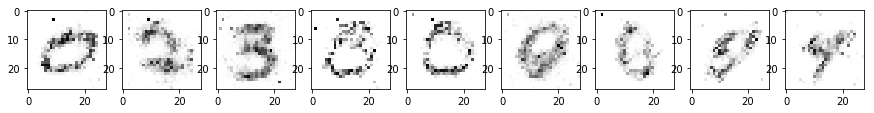

Epoch 19: [D loss: 0.6652538180351257 acc: 0.46875] | [G loss: 0.6343122720718384


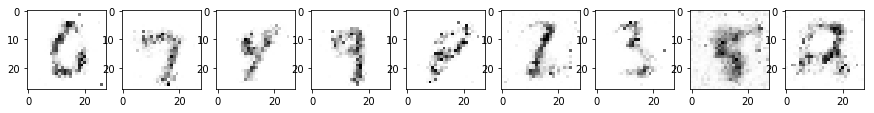

In [89]:
history = train(batch_size=128, epochs=20)

Descriminator loss

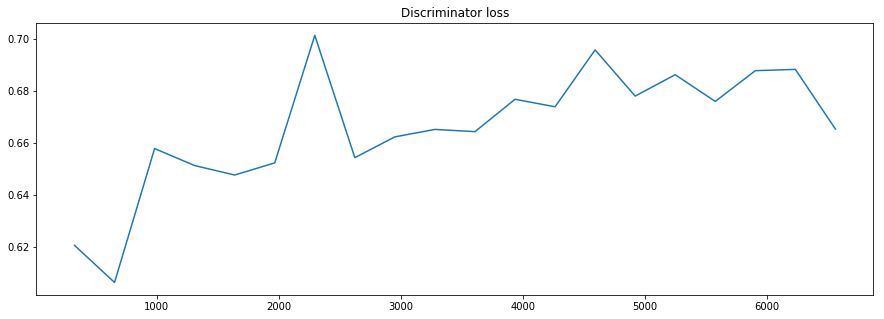

In [92]:
plt.figure(figsize=(15, 5))
plt.title('Discriminator loss')
plt.plot(history['d_loss'])

GAN loss

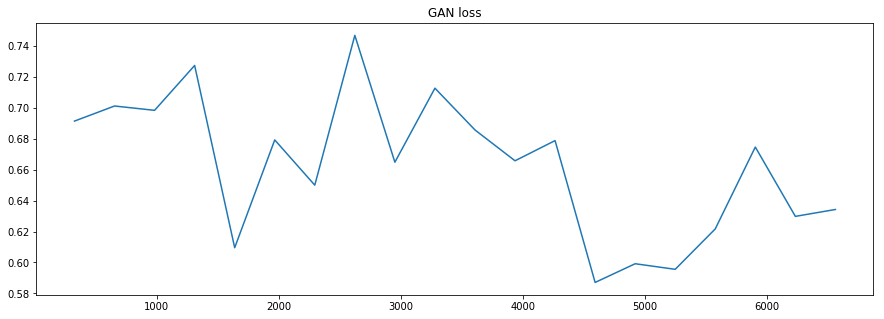

In [93]:
plt.figure(figsize=(15, 5))
plt.title('GAN loss')
plt.plot(history['gan_loss'])

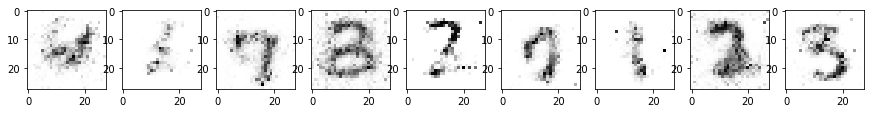

In [97]:
images = generate_images(9)
plt.figure(figsize=(15,5))
for i in range(9):
    plt.subplot('19{0}'.format(i+1))
    plt.imshow(images[i], cmap='gray_r' ,interpolation='nearest')
plt.savefig('generated_digits.png')